# Chp#8: Dimensionality Reduction 

In [1]:
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Projection Methods 

Building a 3D dataset

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## PCA using SVD decomposition

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:,0]
c2 = Vt.T[:,1]

In [4]:
c1

array([0.93636116, 0.29854881, 0.18465208])

In [5]:
c2

array([-0.34027485,  0.90119108,  0.2684542 ])

In [6]:
print(X.shape)
X_centered.shape

(60, 3)


(60, 3)

In [7]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [8]:
S # Eigen vals in diag

array([[6.77645005, 0.        , 0.        ],
       [0.        , 2.82403671, 0.        ],
       [0.        , 0.        , 0.78116597],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.

In [9]:
W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)

In [10]:
X2D_using_svd = X2D
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

## PCA using Scikit-Learn

Sklearn automatically takes care of data centering

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [12]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped

In [13]:
np.allclose(X2D, -X2D_using_svd)

True

Recover the 3d points projected on the plane (PCA 2D subspace)

In [14]:
X3D_inv = pca.inverse_transform(X2D)

As there is some loss in the projection step, the recovered 3D points are not exactly equal to the orignal 3D points:

In [15]:
np.allclose(X3D_inv, X)

False

Compute the reconstruction error:

In [16]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

The inverse transform in the SVD approach looks like this:

In [17]:
X3D_inverse_using_SVD = X2D_using_svd.dot(Vt[:2, :])

The reconstructions from both methods are not identical because Scikit-Learn's PCA class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [18]:
np.allclose(X3D_inverse_using_SVD, X3D_inv-pca.mean_)

True

Principal Components using sklearn

In [19]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Principal Components computed using SVD method

In [20]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

The axes are flipped

###### Explained Variance Ratio 

It indicates the propotion of dataset's variance that lies alongside the axis of each principal component

In [21]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The first dimension explains 84% while the second dimension explains 14% of the variance.  
Less than 1.2% is left for the third axis; this means that it probably carries very little information

By projecing down to 2D, we lose 1.1% of variance:

In [22]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Explained Variance Ratio using SVD approach:

In [23]:
np.square(s) / np.square(s).sum() # s is the diagonal of S

array([0.84248607, 0.14631839, 0.01119554])

#### Figures

In [24]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [25]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Saving figure dataset_3d_plot


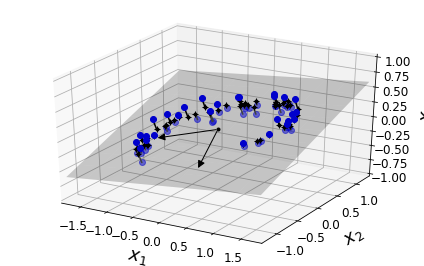

In [26]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

save_fig("dataset_3d_plot")
plt.show()

Saving figure dataset_2d_plot


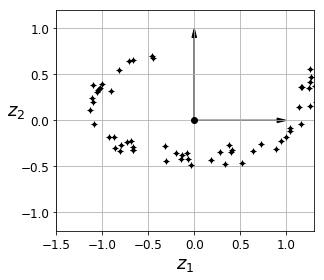

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

# PCA for Compression
### PCA on MNIST 

If we apply PCA while preserving 95% of variance, we'll have:
- 154 features instead of 784 features
- dataset less than 20% of its orignal size

In [28]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [29]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [30]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [31]:
cumsum.shape

(784,)

In [32]:
d

154

Saving figure explained_variance_plot


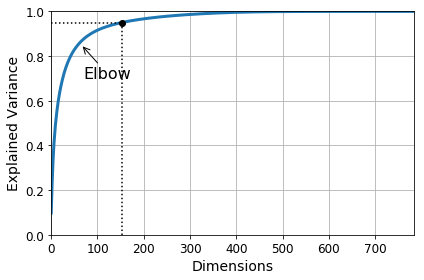

In [33]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 784, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

In [34]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [35]:
pca.n_components_

154

In [36]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557437

In [37]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [38]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure mnist_compression_plot


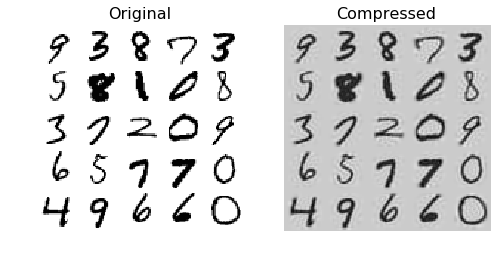

In [39]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [40]:
X_reduced_pca = X_reduced

### Randomized PCA

By defualt, svd_solver is actually set to "auto": scikit-learn automatically uses randomized PCA algorithm if m or n is greater than 500 and d is less than 80% of m or n, or else it uses full SVD approach.  
    If you want to force Scikit-Learn to use full SVD, set the svd_solver hyperparameter to "full"

In [41]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

## Incremental PCA

In [42]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [43]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

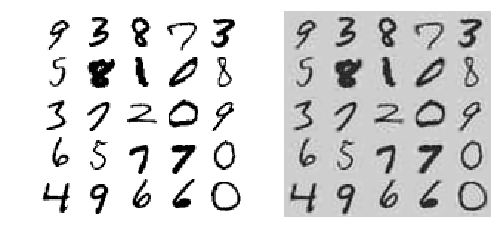

In [44]:
plt.figure(figsize=(7,4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [45]:
X_reduced_inc_pca = X_reduced

Compare MNIST using regular PCA and incremental PCA. First, the means are equal:

In [46]:
np.allclose(pca.mean_, inc_pca.mean_)

True

But the results are not exactly identical. Incremental PCA gives a very good  approx solution, but it's not perfect

In [47]:
np.allclose(X_reduced_inc_pca, X_reduced_pca)

False

### Using memmap()

Create memmap() structure and copy the MNIST data into it. This would be done by a first program:

In [48]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m,n))
X_mm[:] = X_train

Now deleting the memmap() object will trigger its Python finalizer, which ensures that the data is saved to disk.

In [49]:
del X_mm

Next, another program would load the data and use it for training:

In [50]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m,n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [51]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Time Complexity

Regular PCA vs Incremental PCA vs Randomized PCA

In [52]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 1.2 seconds
    IncrementalPCA: 18.1 seconds
    PCA: 1.2 seconds
n_components = 10
    PCA: 1.4 seconds
    IncrementalPCA: 12.0 seconds
    PCA: 1.4 seconds
n_components = 154
    PCA: 4.0 seconds
    IncrementalPCA: 14.1 seconds
    PCA: 4.0 seconds


Now let's compare PCA and Randomized PCA for datasets of different sizes (number of instances)

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

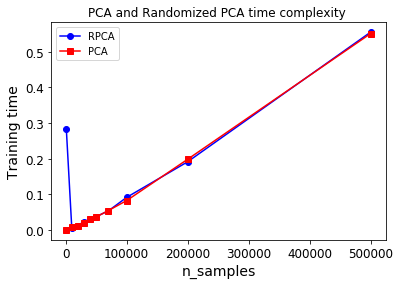

In [53]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

And now let's compare their performance on datasets of 2,000 instances with various numbers of features

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

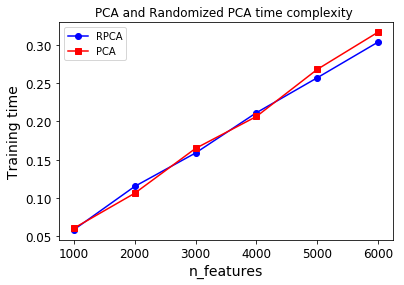

In [54]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

# Kernel PCA

In [55]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [56]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

Saving figure kernel_pca_plot


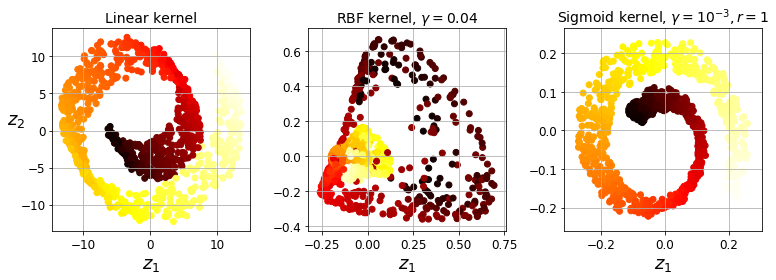

In [57]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

Saving figure preimage_plot


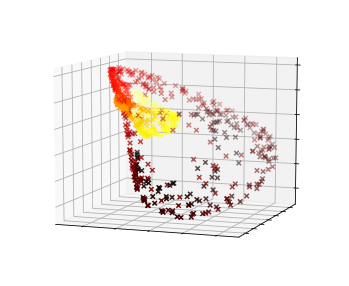

In [58]:
plt.figure(figsize=(6,5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

save_fig("preimage_plot", tight_layout=False)
plt.show()

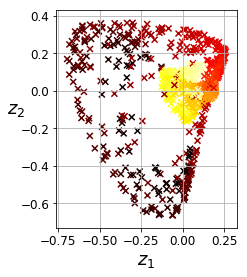

In [59]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

### Selecting a Kernel and Tuning hyperparameters

Use grid search to select the kernel and hyperparameters that gives the best performance

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=None,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRe...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [61]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [62]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [63]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.786308795766104

## LLE

1) It finds the local relationship(dist) of each instance with its closest neighbours  
2) then it maps the instances into a d-dimensional space(where d<n)

In [64]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [65]:
t

array([ 7.07728842,  5.14683186, 11.09123177,  5.12207923,  5.80965653,
       10.40368902,  6.51186808, 11.01300118, 13.35913125,  8.65929831,
        7.84386429,  7.37991815,  6.46805799,  7.70108475,  9.24729685,
        5.36760395, 11.35669318,  7.67814921, 11.73650969,  8.46545616,
       10.44478831, 11.57792963,  8.68736484,  8.42488643,  6.90103518,
        8.87497981,  8.2280328 , 10.21274632,  5.65516248, 11.69946589,
        5.49651101,  5.90202163,  7.75556996, 10.77183596, 14.13218811,
        7.36076715, 10.19972701, 12.93646022, 12.15173585,  6.76781707,
        7.9792256 , 11.51237233,  8.04799107,  9.05423626,  7.01578265,
        7.37642694, 12.49990833, 12.95314845,  6.05795512,  7.35200377,
        9.66199158, 13.20277527, 10.39041192, 11.23240975,  7.37578329,
        7.31841058,  6.18536005, 10.96844735, 13.59814952, 11.13369277,
       12.84580966, 13.30313621, 12.39679199, 12.53257836,  4.96777266,
        6.98326802,  7.22246003,  8.2957971 ,  9.22922981,  7.74

In [66]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

Saving figure lle_unrolling_plot


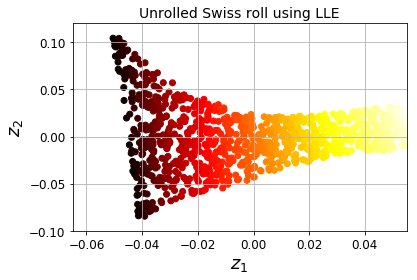

In [67]:
plt.title("Unrolled Swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

## MDS, ISOMAP and t-SNE

**MDS:** reduces dimensionality while trying to preserve the distances between instances  
**ISOMAP:** creates a graph by connecting each instance to its nearest neighbours, then reduces dimensionality while trying to preserve the geodesic distance between the neighbours  
**t-SNE:** reduces dimensionality by trying to keep similar instances close and dissimilar instances appart


In [68]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [69]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [70]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [71]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Saving figure other_dim_reduction_plot


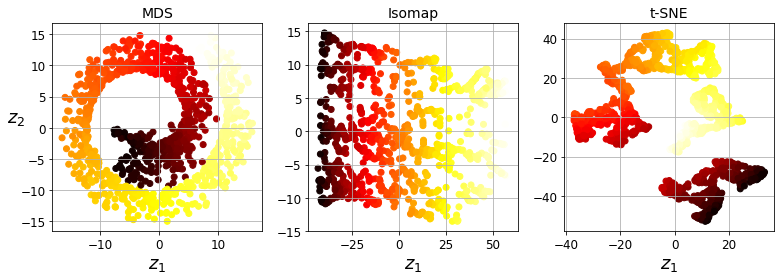

In [72]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

# Exercise

## 9. Performance comparison on MNIST

### i) Without applying PCA

**Loading data**

In [73]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

**Training Random Forest Classifier**

In [74]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [75]:
import time as t

t0 = t.time()
rnd_clf = rnd_clf.fit(X_train, y_train)
t1 = t.time()

In [76]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 32.99s


In [77]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.9705

## ii) With PCA

**Using explained variance ratio of 95%**

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

**Train Random Forest Classifier**

In [79]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)

In [80]:
t0 = t.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = t.time()

In [81]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 79.31s


Training time is almost thrice slower now  
Remember that the dimensionality reduction does not always lead to faster training time: **It depends on the dataset, the model, and the training algorithm**  
If you try a softmax classifier instead of a random forest classifier, you will find that training time is reduced by a factor of 3 when using PCA.

In [82]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

Drop in accuracy by approx 2%

### Softmax Regression

Remember that Softmax Regression is generalized Logistic Regression that supports multiple classes. It doesn't train multiple binary classifiers to be trained and combined at the end.  
Logistic Regression is one vs all by default.  
Set multi_class parameter to "multinomial" to use it as softmax regression

In [83]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)

In [84]:
t0 = t.time()
log_clf.fit(X_train, y_train)
t1 = t.time()

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [85]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 12.33s


In [86]:
y_pred = log_clf.predict(X_test)

In [87]:
accuracy_score(y_pred, y_test)

0.9255

#### With PCA

In [88]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [89]:
print("Training time: {:.2f}s".format(t1 - t0))

Training time: 4.49s


In [90]:
y_pred = log_clf2.predict(X_test_reduced)

In [91]:
accuracy_score(y_pred, y_test)

0.9201

In this case, PCA was useful as as training time reduced by 3 times with just .54% drop in accuracy

## 10.  
### IMP QUES

Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using matplotlib. You can use a scatter to plot to using 10 different colours to map each instance's target class.

Since it takes long time to reduce 60,000 images, we take random subset of 10,000 images

In [92]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]  # [:m] indicates list_size

X = mnist['data'][idx]
y = mnist['target'][idx]

Use t-SNE to reduce the dimensionality to 2D for visualisation:

In [93]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

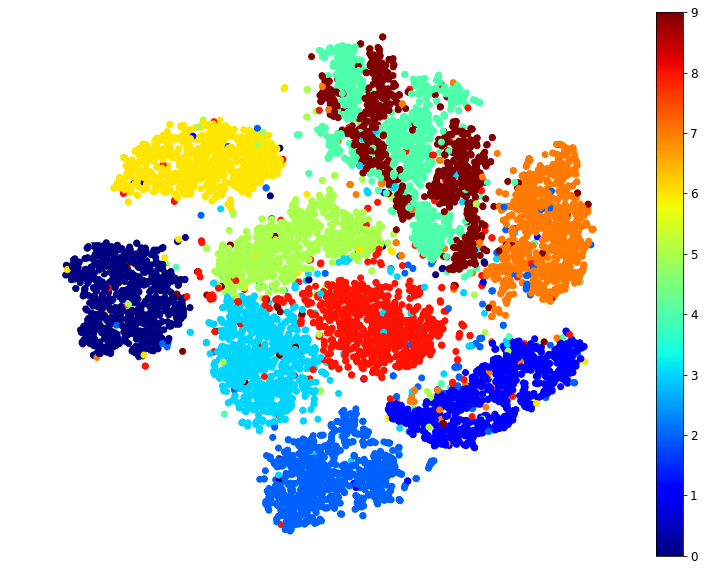

In [94]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet')
plt.axis("off")
plt.colorbar()
plt.show()

3 and 5 overlap alot:-

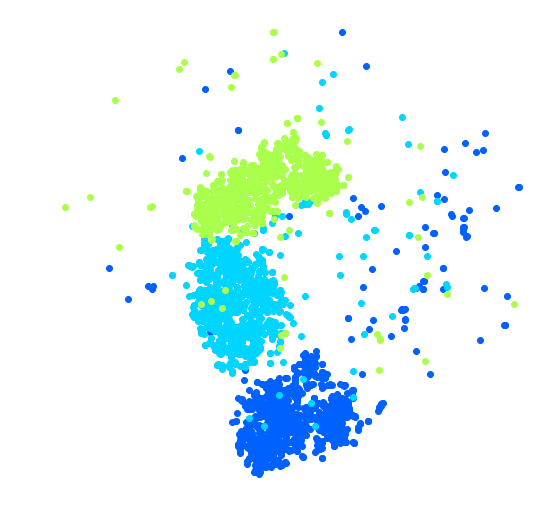

In [95]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c = [cmap(digit / 9)])
plt.axis('off')
plt.show()

Running t-SNE on these 3 digits:

In [96]:
idx = (y == 2) | (y == 3) | (y == 5)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

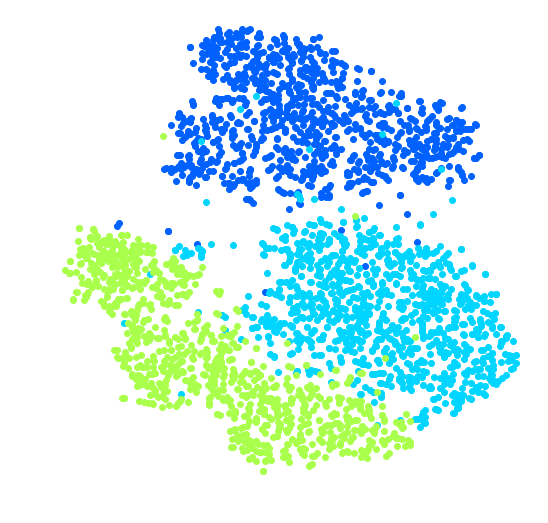

In [97]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit/9)])
plt.axis('off')
plt.show()

Let's create a plot_digits() function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead. This implementation was inspired from one of Scikit-Learn's excellent examples (plot_lle_digits, based on a different digit dataset)

In [98]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13,10)):
    # scale the input feature so that they transform from range 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Create the list of coordinates of the digits plotted so far
    neighbours = np.array([[10., 10.]])
    
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit/9)])
    plt.axis("off")
    ax = plt.gcf().gca() # Get current axis in the current figure
    for i, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbours) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbours = np.r_[neighbours, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[i])), 
                        color=cmap(y[i]/9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[i].reshape(28,28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

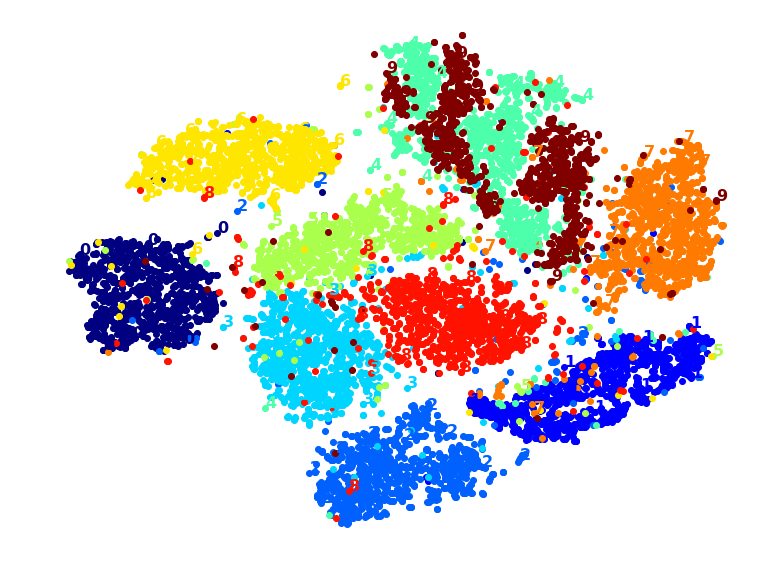

In [99]:
plot_digits(X_reduced, y)

With digit Images:

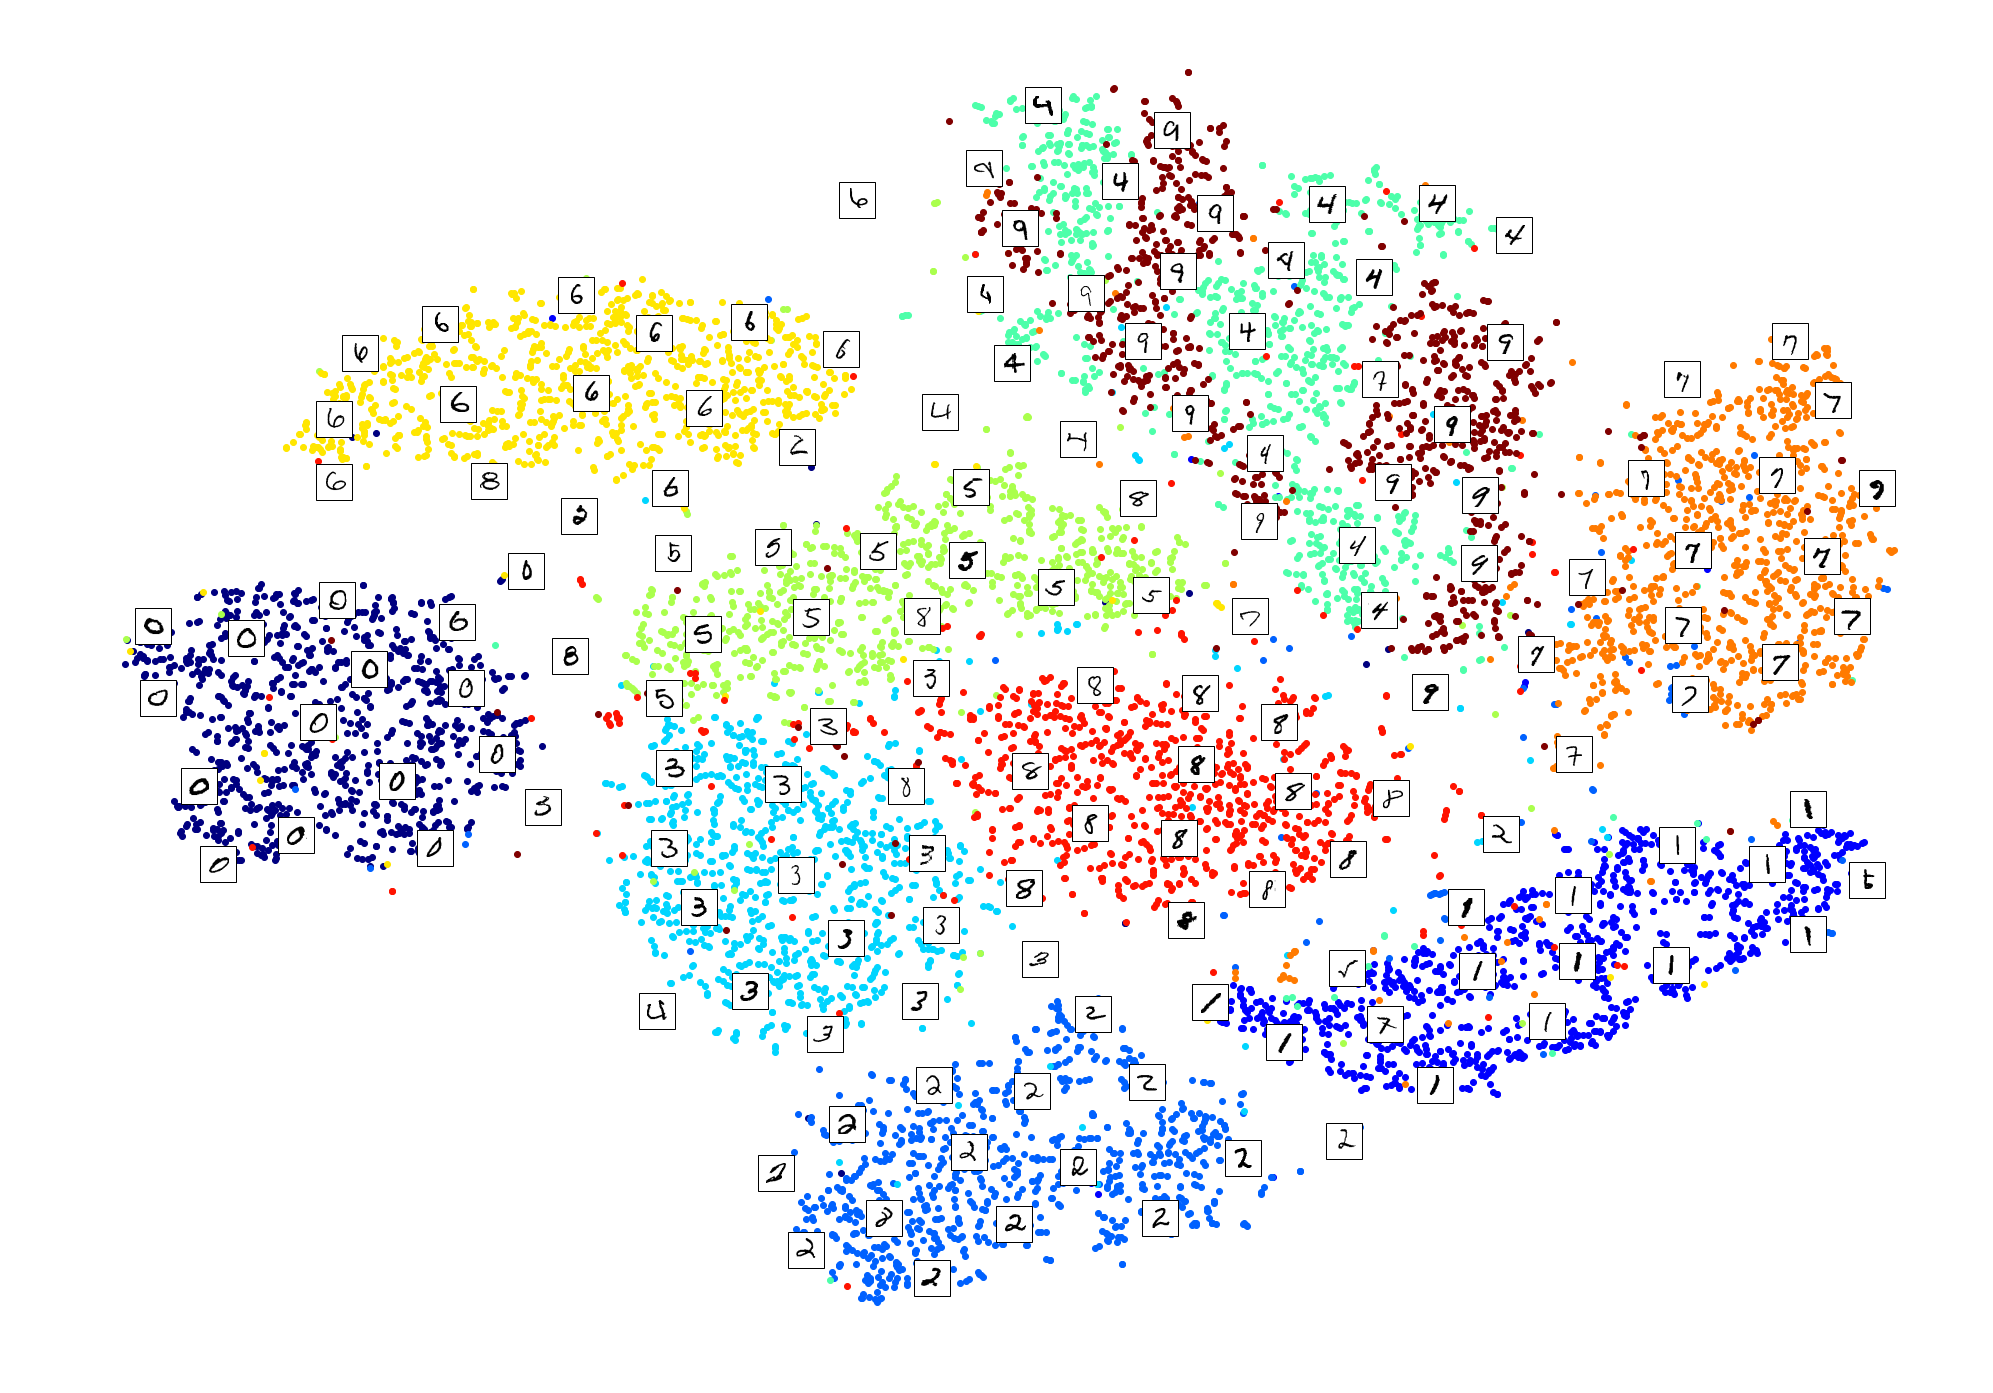

In [100]:
plot_digits(X_reduced, y, images=X, figsize=(35,25))

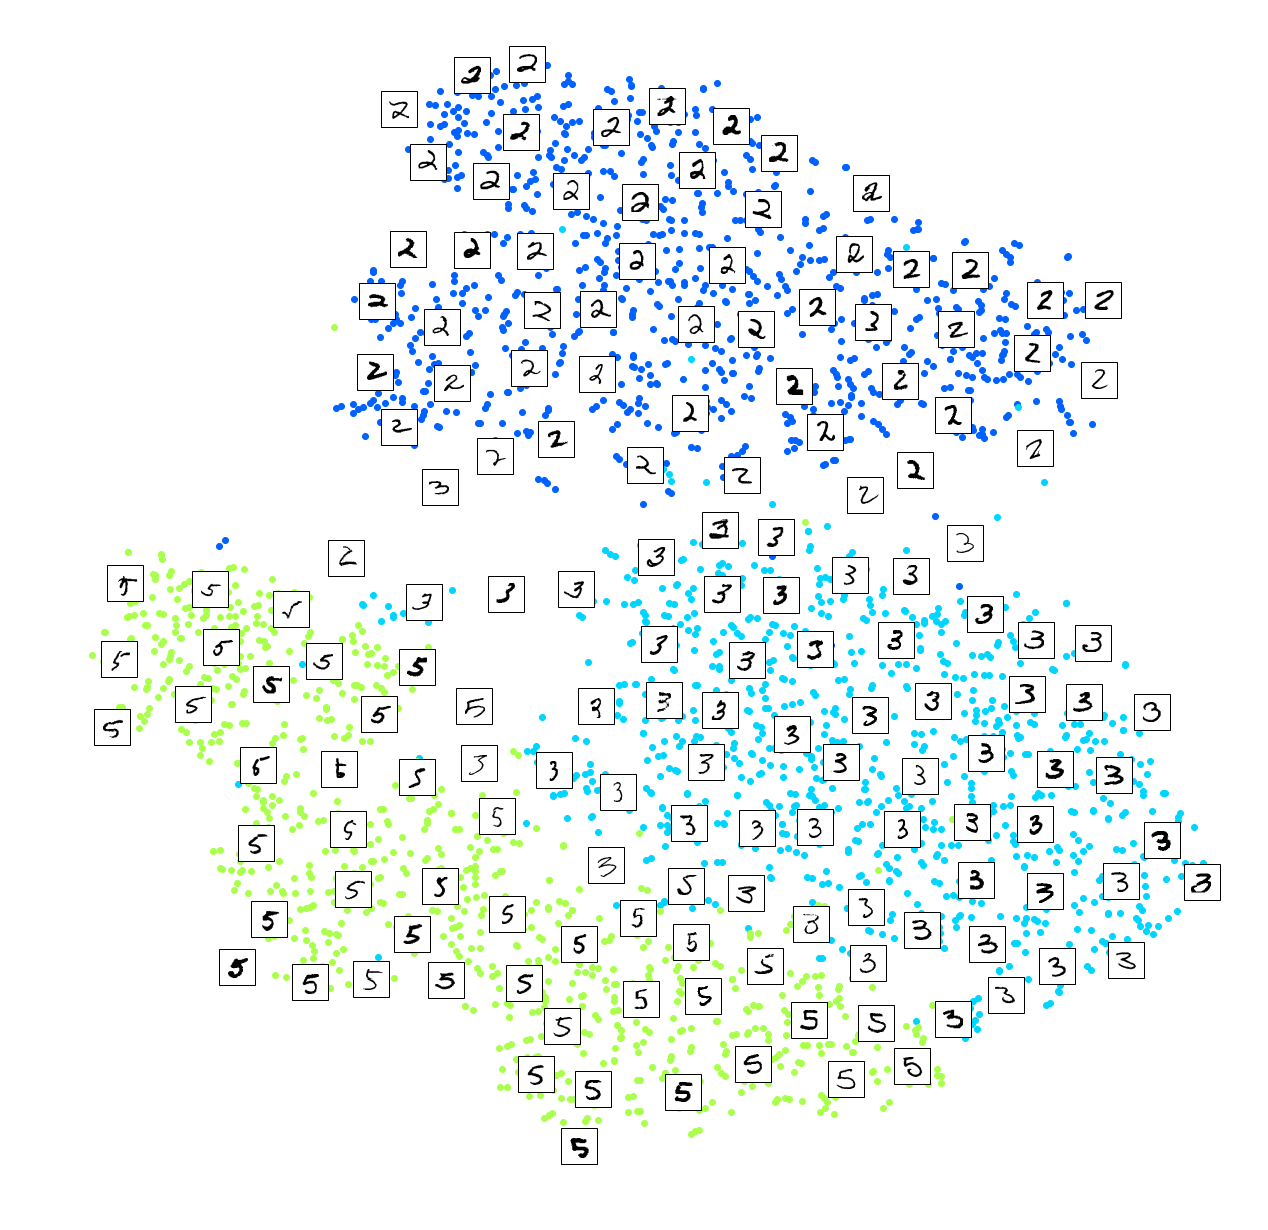

In [101]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

Trying PCA. We also calc time taken by it

PCA took 0.2s


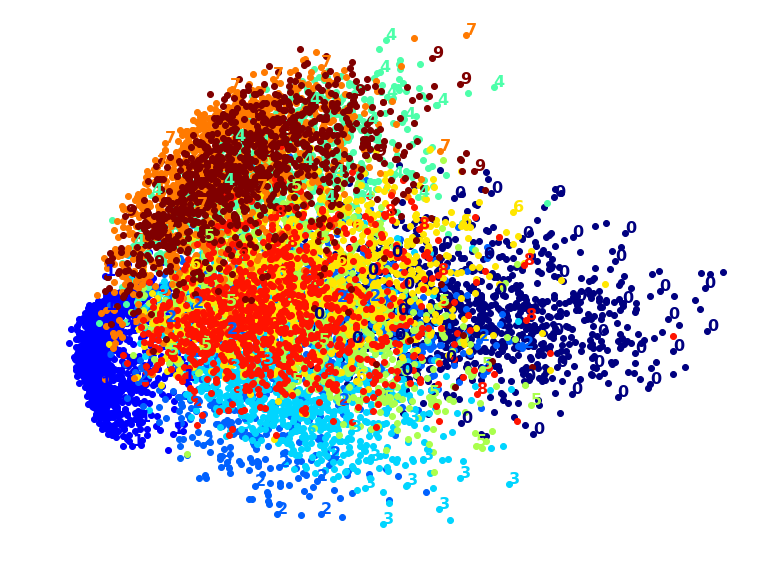

In [102]:
from sklearn.decomposition import PCA
import time as t

t0 = t.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = t.time()
print("PCA took {:.1f}s".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

PCA is much faster than t-SNE

LLE took 130.7s.


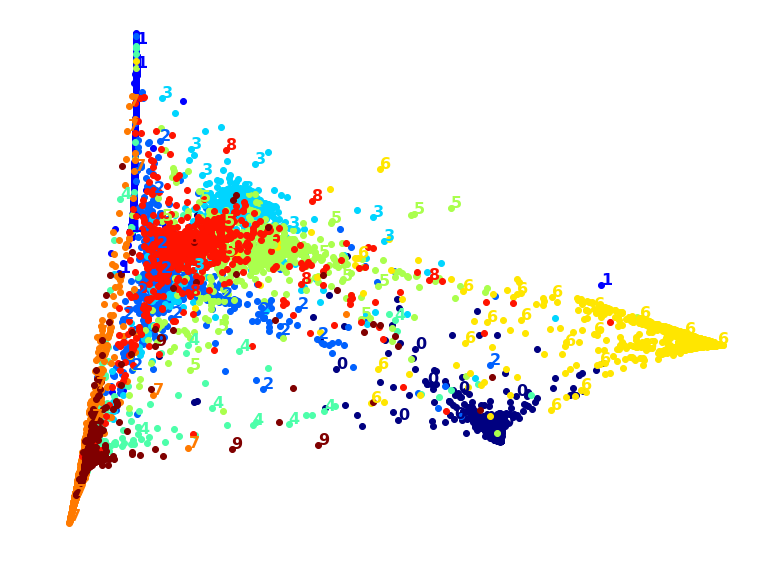

In [103]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = t.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = t.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

PCA + LLE took 38.0s.


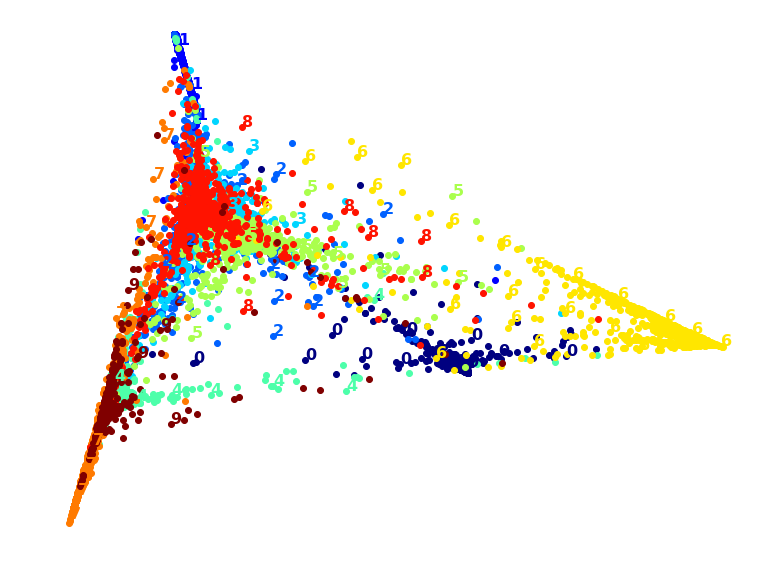

In [104]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])

t0 = t.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = t.time()
print("PCA + LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

Let's try MDS. It's much too long if we run it on 10,000 instances, so let's just try 2,000 for now

It reduces the dimensionality while trying to preserve the space between instances

MDS took 175.6s (on just 2,000 MNIST images instead of 10,000).


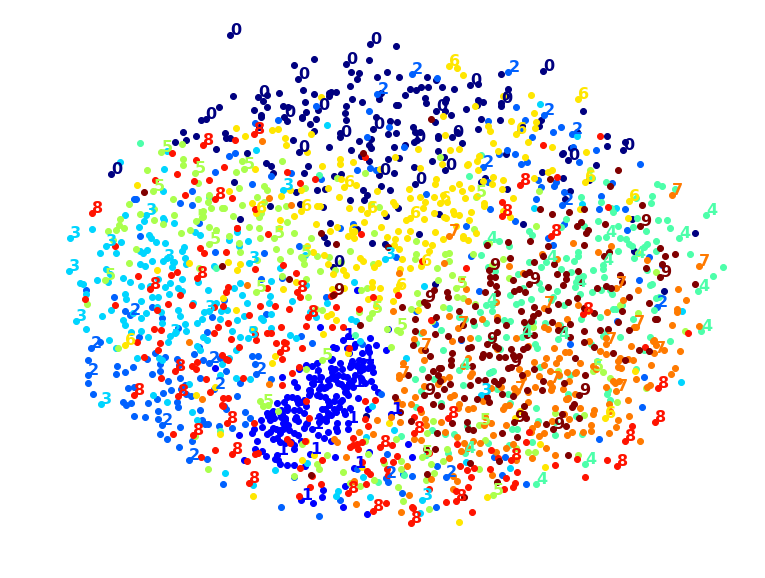

In [105]:
from sklearn.manifold import MDS

m = 2000
t0 = t.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = t.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

It doesn't look good as all the clusters overlap too much. Let's try PCA first

PCA + MDS took 173.9s (on 2000 MNIST images)


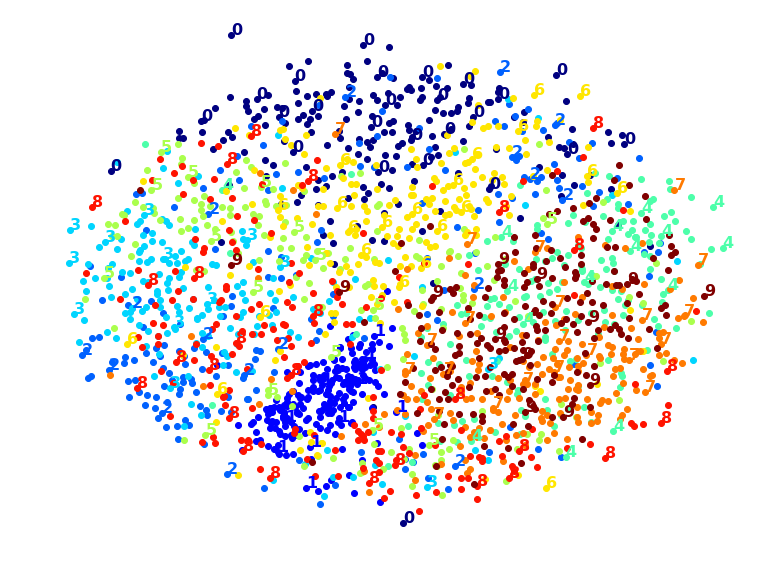

In [106]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])

t0 = t.time()
X_reduced = pca_mds.fit_transform(X[:2000])
t1 = t.time()
print("PCA + MDS took {:.1f}s (on 2000 MNIST images)".format(t1 -t0))
plot_digits(X_reduced, y[:2000])
plt.show()

Same result, no speed up. PCA didn't helped or hurt

Let's check LDA

**Linear Discriminant Analysis(LDA):** is actually a classification algo, but during its training learns the most discriminative axis between the classes, and these axis can be used to define a hyperplane onto which to project the data.  
Benefit is that the projection will keep classes as far as apart.  
It is a good technique to reduce dimensionality before running another classification alogorithm.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA took 1.4s


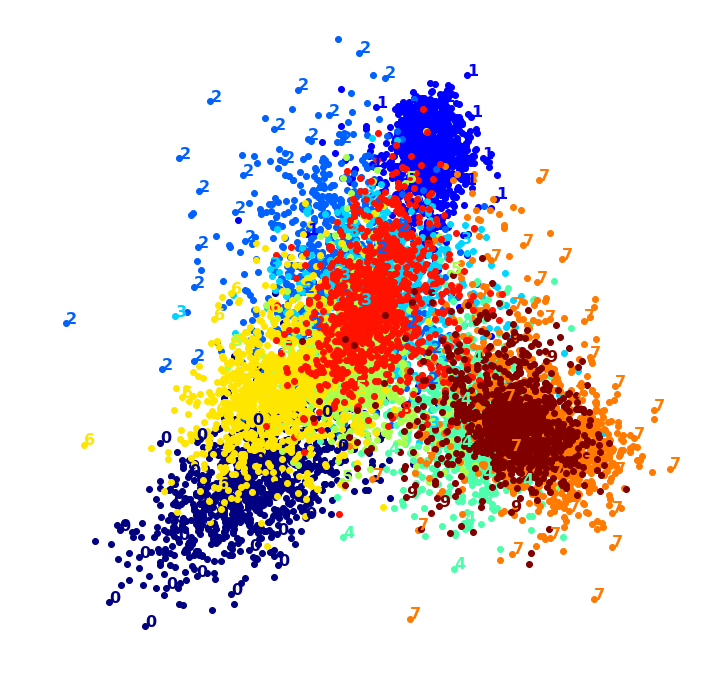

In [107]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = t.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = t.time()
print("LDA took {:.1f}s".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.  

Well, it's pretty clear that t-SNE won this little competition, wouldn't you agree? We did not time it, so let's do that now

t-SNE took 217.6s.


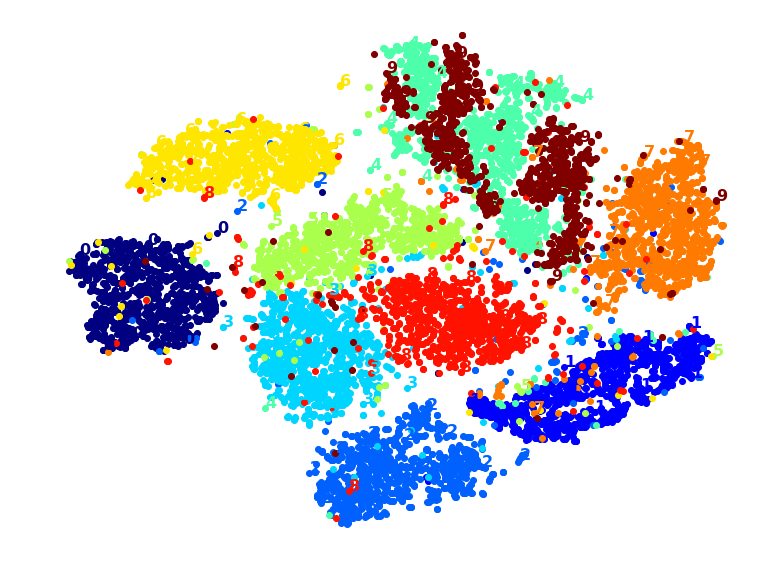

In [108]:
from sklearn.manifold import TSNE

t0 = t.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = t.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

Slower than LLE(127s), much faster than MDS, and the result looks great. Let's see if PCA can speed it up:

PCA + t-SNE took 128.6s


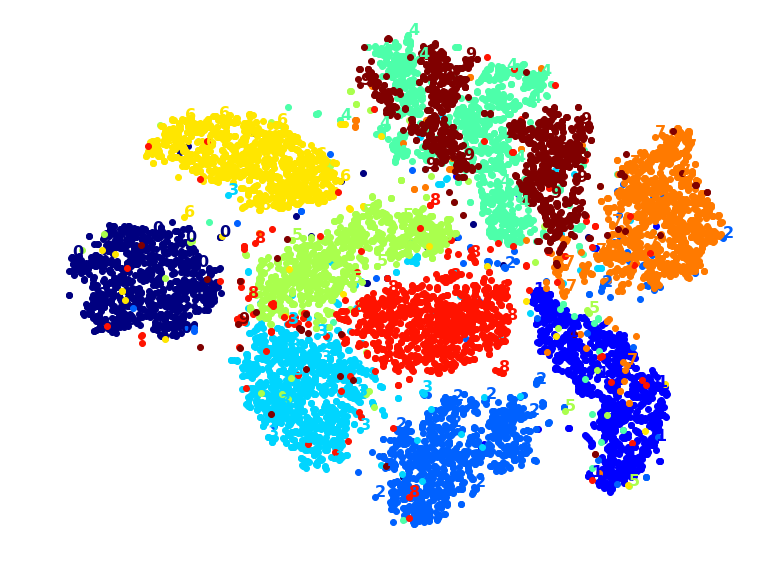

In [109]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])

t0 = t.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = t.time()
print("PCA + t-SNE took {:.1f}s".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

PCA gave 25% speed up, without damaging results. **PCA + t-SNE wins**